# 1. Learning rate
* https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules


In [1]:
from tensorflow import keras

import math
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.losses as losses 

In [2]:
def iou(y_true,y_pred):
    smooth = 0.
    
    # Flatten(행렬의 평탄화 -> 자연수 계산을 가능하도록)
    y_true = tf.reshape(y_true, [-1]) # 차원 생성
    y_pred = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true * y_pred) # 교집합
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    
    score = intersection / (union+smooth)
    
    return score

def dice_coef(y_true,y_pred):
    smooth = 0.
    
    # Flatten(행렬의 평탄화 -> 자연수 계산을 가능하도록)
    y_true = tf.reshape(y_true, [-1]) # 차원 생성
    y_pred = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true * y_pred) # 교집합 
    score = (2 * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    
    return score

def dice_loss(y_true,y_pred):
    loss = 1 - dice_coef(y_true,y_pred)
    
    return loss

def bce_dice_loss(y_true,y_pred):
    loss = 1. * losses.binary_crossentropy(y_true,y_pred) + 1. * dice_loss(y_true,y_pred)
    
    return loss

In [3]:
import albumentations as A

class Augmentation:
    def __init__(self, size, mode='train'):
        if mode == 'train':
            self.transform = A.Compose([
                # 수평
                A.HorizontalFlip(p=0.5),
                # 이동, 크기, 회전을 설정
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15
                ),
                # 최대 8개의 구멍을 dropout 하게됨
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8,
                    max_height=int(0.1 * size),
                    max_width=int(0.1 * size)
                ),
                A.RandomBrightnessContrast(p=0.2)
            ])
    
    def __call__(self, **kwargs): # {image=image, mask=mask}
        if self.transform:
            augmented = self.transform(**kwargs)
            img = augmented['image']
            mask = augmented['mask']
            return img, mask
        
        
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, fold, image_size, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.fold = fold
        self.image_size = image_size
        self.mode = mode
        self.shuffle = shuffle
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
        
        #### https://github.com/tensorflow/models/issues/3134
        #### 파일 이슈 -> 삭제
        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[~self.df['file_name'].isin(invalid_filenames)]
        self.transform = Augmentation(image_size, mode)
        
        self.on_epoch_end()

        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
            return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        batch_x, batch_y = self.get_data(data)
        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['file_name']
            image = cv2.imread(f'data/images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            mask = cv2.imread(f'data/annotations/trimaps/{file_name}.png', cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (self.image_size, self.image_size))
            mask[mask != 1] = 0
            
            if self.mode == 'train':
                image, mask = self.transform(image=image, mask=mask)
            
            image = image.astype('float32')            
            image = image / 255.
            
            mask = mask.astype('float32')
        
            # label = int(r['id']) - 1
            
            batch_x.append(image)
            batch_y.append(mask)
            
        return batch_x, batch_y

    
csv_path = 'data/kfolds.csv'

train_generator = DataGenerator(
    batch_size = 128,
    csv_path = csv_path,
    fold = 1,
    image_size = 128,
    mode = 'train',
    shuffle = True
)

valid_generator = DataGenerator(
    batch_size = 128,
    csv_path = csv_path,
    fold = 1,
    image_size = 256,
    mode = 'val',
    shuffle = True
)

In [4]:
len(train_generator)

46

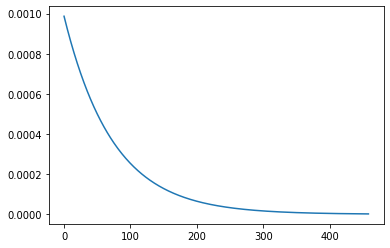

In [6]:
# learning rate: 딥러닝 신경망이 확률적 경사 하강법(SGD) 최적화 알고리즘을 사용하여 학습하기 위한 파라미터
# learning rate decay: 기존의 Learning Rate가 높은 경우 loss 값을 빠르게 내릴 수 있지만, 최적의 학습을 
# 벗어나게 만들고, 낮은 경우 최적의 학습을 할 수 잇지만 너무 오랜 시간이 걸림. 처음 시작 시 Learning rate 값을
# 크게 준 후 일정 epoch마다 값을 감소시켜서 최적의 학습까지 더 빠르게 도달할 수 있게 하는 방법
def decayed_learning_rate(step):
    initial_learning_rate = 0.001
    decay_rate = 0.96
    decay_steps = 3
    
    return initial_learning_rate * decay_rate ** (step/decay_steps)

lrs = [decayed_learning_rate(i) for i in range(1,46 * 10)]
plt.plot(lrs)

In [7]:
from tensorflow.keras import optimizers

lr_schedule = optimizers.schedules.ExponentialDecay(
    0.001, # initial_learning_rate
    decay_steps = 3,
    decay_rate = 0.96
)

optimizer = optimizers.Adam(lr_schedule)

In [8]:
from keras_unet.models import custom_unet

model = custom_unet(
    input_shape = (128,128,3), # 데이터를 넣는 형태 설정
    use_batch_norm = True, # 정규화
    upsample_mode = 'deconv',
    dropout_type = 'spatial',
    num_classes = 1,
    filters = 64,
    dropout = 0.2,
    num_layers = 4,
    output_activation = 'sigmoid'
)

model.compile(optimizer = 'adam',loss = bce_dice_loss, metrics = [iou])
model.summary()

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1728        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm

 conv2d_transpose (Conv2DTransp  (None, 16, 16, 512)  2097664    ['batch_normalization_9[0][0]']  
 ose)                                                                                             
                                                                                                  
 concatenate (Concatenate)      (None, 16, 16, 1024  0           ['conv2d_transpose[0][0]',       
                                )                                 'batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_10 (Conv2D)             (None, 16, 16, 512)  4718592     ['concatenate[0][0]']            
                                                                                                  
 batch_normalization_10 (BatchN  (None, 16, 16, 512)  2048       ['conv2d_10[0][0]']              
 ormalization)                                                                                    
          

In [9]:
history = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs = 10,
    verbose = 1
)

Epoch 1/10
 3/46 [>.............................] - ETA: 1:08:06 - loss: 1.3939 - iou: 0.2649


KeyboardInterrupt

